In [ ]:
## import drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
## imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Optional, just for confirmation

Using device: cuda


In [ ]:
## Import the preprocessed data from INHALE

In [ ]:
# preprocessed_data = pd.read_csv('/content/drive/MyDrive/results/processed_merged_dataset_normalise_per_user.csv')
train_data = pd.read_csv('/content/drive/MyDrive/results/processed_train_normalised.csv')
test_data = pd.read_csv('/content/drive/MyDrive/results/processed_test_normalised.csv')
train_data.drop(columns=["Unnamed: 0"], inplace=True)
test_data.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
train_data

,br_avg,br_std,act_level,step_count,pm2_5_x,pm2_5_y,pm10,no,no2,o3,...,season_Winter,is_weekend_False,is_weekend_True,yearly_sin,yearly_cos,hour_sin,hour_cos,dow_sin,dow_cos,patient_id
0,3.125279,1.733331,0.073622,1.945910,0.978326,1.576915,1.887070,0.019803,2.640485,4.243626,...,0.0,1.0,0.0,-0.746972,0.664855,0.707107,-0.707107,-0.433884,-0.900969,INH002
1,2.824465,1.984122,0.076402,3.713572,1.026042,1.576915,1.887070,0.019803,2.640485,4.243626,...,0.0,1.0,0.0,-0.746972,0.664855,0.707107,-0.707107,-0.433884,-0.900969,INH002
2,3.107214,1.142391,0.106359,3.332205,0.993252,1.576915,1.887070,0.019803,2.640485,4.243626,...,0.0,1.0,0.0,-0.746972,0.664855,0.707107,-0.707107,-0.433884,-0.900969,INH002
3,3.151132,0.447699,0.124063,2.890372,1.264127,1.576915,1.887070,0.019803,2.640485,4.243626,...,0.0,1.0,0.0,-0.746972,0.664855,0.707107,-0.707107,-0.433884,-0.900969,INH002
4,2.994754,2.029197,0.039465,0.000000,1.036737,1.576915,1.887070,0.019803,2.640485,4.243626,...,0.0,1.0,0.0,-0.746972,0.664855,0.707107,-0.707107,-0.433884,-0.900969,INH002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574929,2.746083,0.673601,0.006096,0.000000,0.792993,2.427454,2.957511,0.000000,2.551006,4.243626,...,0.0,1.0,0.0,-0.987349,0.158559,-0.258819,0.965926,0.781831,0.623490,INH139
574930,2.831237,1.242047,0.006261,0.000000,0.698135,2.427454,2.957511,0.000000,2.551006,4.243626,...,0.0,1.0,0.0,-0.987349,0.158559,-0.258819,0.965926,0.781831,0.623490,INH139
574931,2.799052,1.019858,0.008980,0.000000,0.741937,2.427454,2.957511,0.000000,2.551006,4.243626,...,0.0,1.0,0.0,-0.987349,0.158559,-0.258819,0.965926,0.781831,0.623490,INH139
574932,2.800097,0.726140,0.006749,0.000000,0.802002,2.427454,2.957511,0.000000,2.551006,4.243626,...,0.0,1.0,0.0,-0.987349,0.158559,-0.258819,0.965926,0.781831,0.623490,INH139


In [ ]:
test_data

,br_avg,br_std,act_level,step_count,pm2_5_x,pm2_5_y,pm10,no,no2,o3,...,season_Winter,is_weekend_False,is_weekend_True,yearly_sin,yearly_cos,hour_sin,hour_cos,dow_sin,dow_cos,patient_id
0,3.076146,0.209754,0.042995,0.000000,0.974560,1.000632,1.205971,0.512824,2.628285,4.293742,...,1.0,1.0,0.0,0.801361,0.598181,0.707107,-0.707107,0.781831,0.62349,INH001
1,2.832208,1.781761,0.091346,0.000000,1.078410,1.000632,1.205971,0.512824,2.628285,4.293742,...,1.0,1.0,0.0,0.801361,0.598181,0.707107,-0.707107,0.781831,0.62349,INH001
2,2.880227,2.141613,0.109832,0.000000,1.098612,1.000632,1.205971,0.512824,2.628285,4.293742,...,1.0,1.0,0.0,0.801361,0.598181,0.707107,-0.707107,0.781831,0.62349,INH001
3,2.775554,1.767832,0.106791,2.079442,1.181727,1.000632,1.205971,0.512824,2.628285,4.293742,...,1.0,1.0,0.0,0.801361,0.598181,0.707107,-0.707107,0.781831,0.62349,INH001
4,3.311010,0.324131,0.268083,4.276666,1.342865,1.000632,1.205971,0.512824,2.628285,4.293742,...,1.0,1.0,0.0,0.801361,0.598181,0.707107,-0.707107,0.781831,0.62349,INH001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248168,2.761497,2.034737,0.183538,4.094345,0.565314,3.563883,3.637323,0.000000,2.859340,4.723664,...,0.0,1.0,0.0,-0.895839,-0.444378,-0.258819,0.965926,0.000000,1.00000,INH138
248169,2.910757,1.275246,0.079567,2.197225,0.524729,3.563883,3.637323,0.000000,2.859340,4.723664,...,0.0,1.0,0.0,-0.895839,-0.444378,-0.258819,0.965926,0.000000,1.00000,INH138
248170,2.831669,0.628619,0.146926,0.000000,0.609766,3.563883,3.637323,0.000000,2.859340,4.723664,...,0.0,1.0,0.0,-0.895839,-0.444378,-0.258819,0.965926,0.000000,1.00000,INH138
248171,2.814761,1.432203,0.008802,0.000000,0.506818,3.563883,3.637323,0.000000,2.859340,4.723664,...,0.0,1.0,0.0,-0.895839,-0.444378,-0.258819,0.965926,0.000000,1.00000,INH138


In [ ]:
print(len(train_data["patient_id"].unique()),len(test_data["patient_id"].unique()))

30 14


In [ ]:
print(train_data["patient_id"].unique(), test_data["patient_id"].unique())

['INH002' 'INH111' 'INH004' 'INH006' 'INH007' 'INH012' 'INH013' 'INH015'
 'INH127' 'INH018' 'INH023' 'INH024' 'INH027' 'INH028' 'INH100' 'INH101'
 'INH102' 'INH103' 'INH107' 'INH108' 'INH109' 'INH110' 'INH112' 'INH115'
 'INH117' 'INH119' 'INH120' 'INH123' 'INH135' 'INH139'] ['INH001' 'INH003' 'INH010' 'INH011' 'INH014' 'INH017' 'INH025' 'INH106'
 'INH114' 'INH113' 'INH121' 'INH128' 'INH131' 'INH138']


## LEARNING MORE ABOUT PATIENTS HERE!

In [ ]:
# ## USEFUL AFTER DATA DEBUGGING

# patient_ids = ["INH100", "INH120", "INH101", "INH112", "INH108",  ## of 100
#                "INH007", "INH024", "INH012", "INH017", "INH106", ## of 00
#               "INH014", "INH103", "INH119", "INH114", "INH115",
#                ## Second stage more data
#               "INH113", "INH123", "INH111", "INH025", "INH138"

#               ]

#               # I dont know why but they don't seem to be workin!
#               # "INH128", "INH102",
#               #  "INH003" , "INH015"]

#  #"INH013",
# #      , , "INH113",
# #     , "INH014", "INH103", "INH119", "INH114", "INH115", "INH123"
# #     "INH111", ", "INH025", "INH138", "INH127", "INH027", "INH135"
# #     # "INH107", "INH139", "INH121", "INH131", "INH023", "INH109", "INH006",
# #     # "INH029", "INH110", "INH117", "INH004", "INH028", "INH010", "INH002",
# #     # "INH018", "INH001", "INH011"]

# # ]

# # # Filter only rows where 'patient_id' is in patient_ids
# clean_data = preprocessed_data[preprocessed_data['patient_id'].isin(patient_ids)].copy()


# print(len(clean_data["patient_id"].unique()))

20


## DATA DEBUGGING

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Step 1: Define which columns to scale
scale_cols = ['latitude_x', 'longitude_x', 'lat_round', 'lon_round']

# Step 2: Fit on train only
scaler = StandardScaler()
scaler.fit(train_data[scale_cols])

# Step 3: Transform train and test
train_df_scaled = train_data.copy()
test_df_scaled = test_data.copy()

train_df_scaled[scale_cols] = scaler.transform(train_data[scale_cols])
test_df_scaled[scale_cols] = scaler.transform(test_data[scale_cols])



In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # === Load your data ===
# # Assuming it's in a DataFrame called `df`
# df = clean_data.copy()

# # === Drop non-numeric columns like patient_id ===
# df_numeric = df.select_dtypes(include='number')  # drops patient_id__patient_id

# # === Compute correlation matrix ===
# corr_matrix = df_numeric.corr(method='pearson')

# # === Plot heatmap ===
# plt.figure(figsize=(24, 14))
# sns.heatmap(
#     corr_matrix,
#     annot=True,
#     fmt=".2f",
#     cmap='coolwarm',
#     vmin=-1,
#     vmax=1,
#     linewidths=0.5
# )
# plt.title("📈 Feature Correlation Heatmap")
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()


In [ ]:
## Dropping some non useful features

train_df_scaled.drop(columns=['pm2_5_y','lat_round','lon_round', 'temperature','humidity', 'activity_Undefined'], inplace=True)

test_df_scaled.drop(columns=['pm2_5_y','lat_round','lon_round', 'temperature','humidity', 'activity_Undefined'], inplace=True)

# DATA SHAPE

# WHAT ABOUT SEQUENCE TIME CONSINSTENCY?
# Are they continuous? Is there any gap
# Are sequences all the same lenght?
# Do sequences leak across patients?


## DATASET AND DATALOADER

In [ ]:
from torch.utils.data import DataLoader, Dataset
class PatientForecastDataset(Dataset):
    def __init__(self, dataframe, patient_ids, seq_len=50, forecast_steps=10, stride=1):
        """
        Args:
            dataframe (pd.DataFrame): Full dataset including all patients
            patient_ids (list): List of patient IDs to include in this dataset (train or test)
            seq_len (int): Length of the input sequence
            forecast_steps (int): Number of steps to forecast
            stride (int): Step size to slide the window
        """
        self.seq_len = seq_len
        self.forecast_steps = forecast_steps
        self.sequences = []

        # Determine feature columns dynamically from the dataframe,
        feature_columns = [col for col in dataframe.columns if col != 'patient_id']

        for pid in patient_ids:
            ## Filter for first patient_id
            patient_data = dataframe[dataframe['patient_id'] == pid]
            ## Keep only feature columns and reset index
            patient_data = patient_data[feature_columns].reset_index(drop=True)
            ## Import it into tensor
            data_tensor = torch.tensor(patient_data.values, dtype=torch.float32)
            total_timesteps = data_tensor.shape[0]

            # Ensure enough data exists for at least one full sequence + forecast
            if total_timesteps < seq_len + forecast_steps:
                print(f"Warning: Patient {pid} does not have enough data for a sequence ({total_timesteps} < {seq_len + forecast_steps}). Skipping.")
                continue


            num_full_sequences = (total_timesteps - (seq_len + forecast_steps)) // stride + 1


            if num_full_sequences <= 0:
                 print(f"Warning: Patient {pid} does not have enough data points after considering seq_len, forecast_steps, and stride. Skipping.")
                 continue  # Not enough data for even one sequence


            for i in range(num_full_sequences):
                start = i * stride
                end = start + seq_len + forecast_steps
                sequence = data_tensor[start:end]

                input_part = sequence[:seq_len]
                future_part = sequence[seq_len:]

                self.sequences.append((input_part, future_part))

        print(f"Loaded {len(self.sequences)} sequences for {len(patient_ids)} patients.")
        if len(self.sequences) == 0:
             print("No sequences were created. Check your data, seq_len, forecast_steps, and stride.")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

In [ ]:
## Here I am creating an instance of the class

import numpy as np
import torch
from torch.utils.data import DataLoader

# dataframe_to_use = clean_data.copy()

# # === Split by Patients ===

# np.random.seed(1)
# unique_patients = dataframe_to_use['patient_id'].unique()
# np.random.shuffle(unique_patients)

# train_frac = 0.7
# split_idx = int(train_frac * len(unique_patients))

# train_patients = unique_patients[:split_idx]
# test_patients = unique_patients[split_idx:]

# print(f"Train Patients: {len(train_patients)}, Test Patients: {len(test_patients)}")

# === Instantiate Datasets ===
seq_len = 100
forecast_steps = 60
batch_size = 256
stride = 10

train_dataset_pytorch = PatientForecastDataset(train_df_scaled, train_df_scaled["patient_id"].unique(), seq_len, forecast_steps, stride = stride)
test_dataset_pytorch = PatientForecastDataset(test_df_scaled, test_df_scaled["patient_id"].unique(), seq_len, forecast_steps, stride = stride)

# print(f"Train sequences: {len(train_dataset)}, Test sequences: {len(test_dataset)}")

# === DataLoaders ===
train_loader = DataLoader(train_dataset_pytorch, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset_pytorch, batch_size=batch_size, shuffle=False)


Loaded 57031 sequences for 30 patients.
Loaded 24602 sequences for 14 patients.


In [ ]:
train_df_scaled["patient_id"].unique()

array(['INH002', 'INH111', 'INH004', 'INH006', 'INH007', 'INH012',
       'INH013', 'INH015', 'INH127', 'INH018', 'INH023', 'INH024',
       'INH027', 'INH028', 'INH100', 'INH101', 'INH102', 'INH103',
       'INH107', 'INH108', 'INH109', 'INH110', 'INH112', 'INH115',
       'INH117', 'INH119', 'INH120', 'INH123', 'INH135', 'INH139'],
      dtype=object)

In [ ]:
test_df_scaled["patient_id"].unique()

array(['INH001', 'INH003', 'INH010', 'INH011', 'INH014', 'INH017',
       'INH025', 'INH106', 'INH114', 'INH113', 'INH121', 'INH128',
       'INH131', 'INH138'], dtype=object)

## TRANSFORMER ONE STEP ALL

In [ ]:
import torch
import torch.nn as nn
import math
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# === Positional Encoding ===
class PositionalEncoding(nn.Module):
    """
    Implements the standard sinusoidal positional encoding.
    """
    def __init__(self, d_model, max_len=200):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float) *
            (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: (seq_len, batch, d_model)
        x = x + self.pe[:x.size(0)]
        return x


# === TimeSeries Transformer ===
class TimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        feature_size: int,
        d_model: int = 64,
        nhead: int = 8,
        num_layers: int = 3,
        dim_feedforward: int = 128,
        dropout: float = 0.1,
        forecast_steps: int = 10,
    ):
        super().__init__()
        # project input features to model dimension
        self.input_proj = nn.Linear(feature_size, d_model)
        # positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        # transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        # output decoder: mapping last hidden to forecast steps
        self.decoder = nn.Linear(d_model, forecast_steps)
        self.d_model = d_model

    def forward(self, src: torch.Tensor) -> torch.Tensor:
        """
        Args:
            src: (seq_len, batch, feature_size)
        Returns:
            out: (batch, forecast_steps)
        """
        # project and scale
        x = self.input_proj(src) * math.sqrt(self.d_model)
        # add positional encoding
        x = self.pos_encoder(x)
        # encode
        enc_out = self.transformer_encoder(x)  # (seq_len, batch, d_model)
        # take last time-step
        last = enc_out[-1, :, :]               # (batch, d_model)
        # predict
        out = self.decoder(last)               # (batch, forecast_steps)
        return out

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs=30,
    patience=10,
    min_delta=1e-4
):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.permute(1, 0, 2).to(device)
            targets = targets[:, :, 0].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.permute(1, 0, 2).to(device)
                targets = targets[:, :, 0].to(device)

                outputs = model(inputs)
                val_loss = criterion(outputs, targets)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")

        # Early Stopping with min_delta
        if best_val_loss - avg_val_loss > min_delta:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch} - Best Val Loss: {best_val_loss:.6f}")
                break


## CALLING THE MODEL

In [ ]:
# === Imports ===
import torch
import torch.nn as nn

## Let's see if it improves by changing these hyperparameters
## let's try a long seq_len

# === Hyper‑params ===
batch_size     = batch_size
seq_len        = seq_len
forecast_steps = 60
epochs         = 30
patience = 5
lr             = 1e-3
device         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_features = len(train_df_scaled.columns) - 1  # Exclude the 'patient_id__patient_id' column

model = TimeSeriesTransformer(
    feature_size=num_features,
    d_model=128,            # Expand latent space further
    nhead=16,               # Maintain d_model % nhead == 0
    num_layers=12,          # Slightly deeper
    dim_feedforward=512,    # More non-linearity
    dropout=0.3,            # Keep regularization consistent
    forecast_steps=forecast_steps
).to(device)

# === Optimizer & Scheduler ===
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.5)
criterion = nn.MSELoss()

# === Train ===
print("▶️  Starting training …")
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=epochs
)

▶️  Starting training …
Epoch 1/30 - Train Loss: 0.300227 - Val Loss: 0.034374
Epoch 2/30 - Train Loss: 0.035016 - Val Loss: 0.027300
Epoch 3/30 - Train Loss: 0.030216 - Val Loss: 0.034540
Epoch 4/30 - Train Loss: 0.026215 - Val Loss: 0.032409
Epoch 5/30 - Train Loss: 0.024659 - Val Loss: 0.029488
Epoch 6/30 - Train Loss: 0.023967 - Val Loss: 0.029796
Epoch 7/30 - Train Loss: 0.023107 - Val Loss: 0.028921
Epoch 8/30 - Train Loss: 0.022857 - Val Loss: 0.028311
Epoch 9/30 - Train Loss: 0.022678 - Val Loss: 0.030993
Epoch 10/30 - Train Loss: 0.022537 - Val Loss: 0.030156
Epoch 11/30 - Train Loss: 0.022110 - Val Loss: 0.029943


KeyboardInterrupt: 

In [ ]:
## Evaluate the model after training

def evaluate_model(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device,
):
    """w
    Runs model evaluation over the provided dataloader.

    Returns:
        preds (torch.Tensor): Shape (total_samples, forecast_steps)
        trues (torch.Tensor): Shape (total_samples, forecast_steps)
    """
    model.eval()
    all_preds = []
    all_trues = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            # inputs: (batch, seq_len, features)
            # targets: (batch, forecast_steps, features)

            inputs = inputs.permute(1, 0, 2).to(device)  # (seq_len, batch, features)

            outputs = model(inputs)  # (batch, forecast_steps)
            targets = targets[:, :, 0]  # (batch, forecast_steps) — first feature only

            all_preds.append(outputs.cpu())
            all_trues.append(targets.cpu())

    preds = torch.cat(all_preds, dim=0)  # (total_samples, forecast_steps)
    trues = torch.cat(all_trues, dim=0)  # (total_samples, forecast_steps)

    return preds, trues

preds, trues = evaluate_model(
    model=model,
    dataloader=val_loader,
    device=device
)

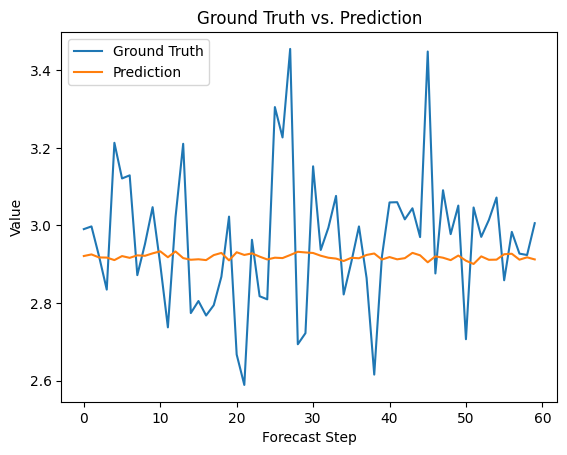

In [ ]:
## PLOTTING THE RESULTS
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have:
# preds, trues = evaluate_model(...)

# Convert to numpy arrays (if they’re PyTorch tensors)
if hasattr(preds, 'detach'):
    preds_np = preds.detach().cpu().numpy()
else:
    preds_np = np.array(preds)
if hasattr(trues, 'detach'):
    trues_np = trues.detach().cpu().numpy()
else:
    trues_np = np.array(trues)

# Plot the first example in the batch
plt.figure()
plt.plot(trues_np[0], label='Ground Truth')
plt.plot(preds_np[0], label='Prediction')
plt.xlabel('Forecast Step')
plt.ylabel('Value')
plt.title('Ground Truth vs. Prediction')
plt.legend()
plt.show()

In [ ]:
import torch

forecast_steps = preds.shape[1]  # 20 in your case
minutes_per_hour = 60
preds_hourly = []
trues_hourly = []

# For simplicity, only keep full-hour chunks
usable_steps = (forecast_steps // minutes_per_hour) * minutes_per_hour

if usable_steps == 0:
    raise ValueError(f"forecast_steps ({forecast_steps}) is less than 60 minutes, can't compute hourly aggregates.")

for i in range(0, usable_steps, minutes_per_hour):
    hourly_pred = preds[:, i:i + minutes_per_hour].mean(dim=1)  # Average over each hour
    hourly_true = trues[:, i:i + minutes_per_hour].mean(dim=1)

    preds_hourly.append(hourly_pred.unsqueeze(1))
    trues_hourly.append(hourly_true.unsqueeze(1))

# Stack along hour dimension
preds_hourly = torch.cat(preds_hourly, dim=1)  # shape: (num_samples, num_hours)
trues_hourly = torch.cat(trues_hourly, dim=1)

print(f"Hourly Predictions shape: {preds_hourly.shape}")  # (num_samples, num_hours)


Hourly Predictions shape: torch.Size([24602, 1])


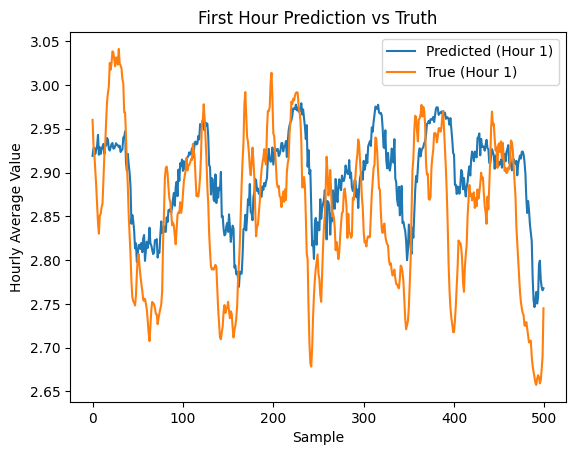

In [ ]:
import matplotlib.pyplot as plt

plt.plot(preds_hourly[:500, 0].numpy(), label='Predicted (Hour 1)')
plt.plot(trues_hourly[:500, 0].numpy(), label='True (Hour 1)')
plt.xlabel("Sample")
plt.ylabel("Hourly Average Value")
plt.title("First Hour Prediction vs Truth")
plt.legend()
plt.show()